In [1]:
import math
import matplotlib.pyplot as plt
import gprsim
import numpy as np

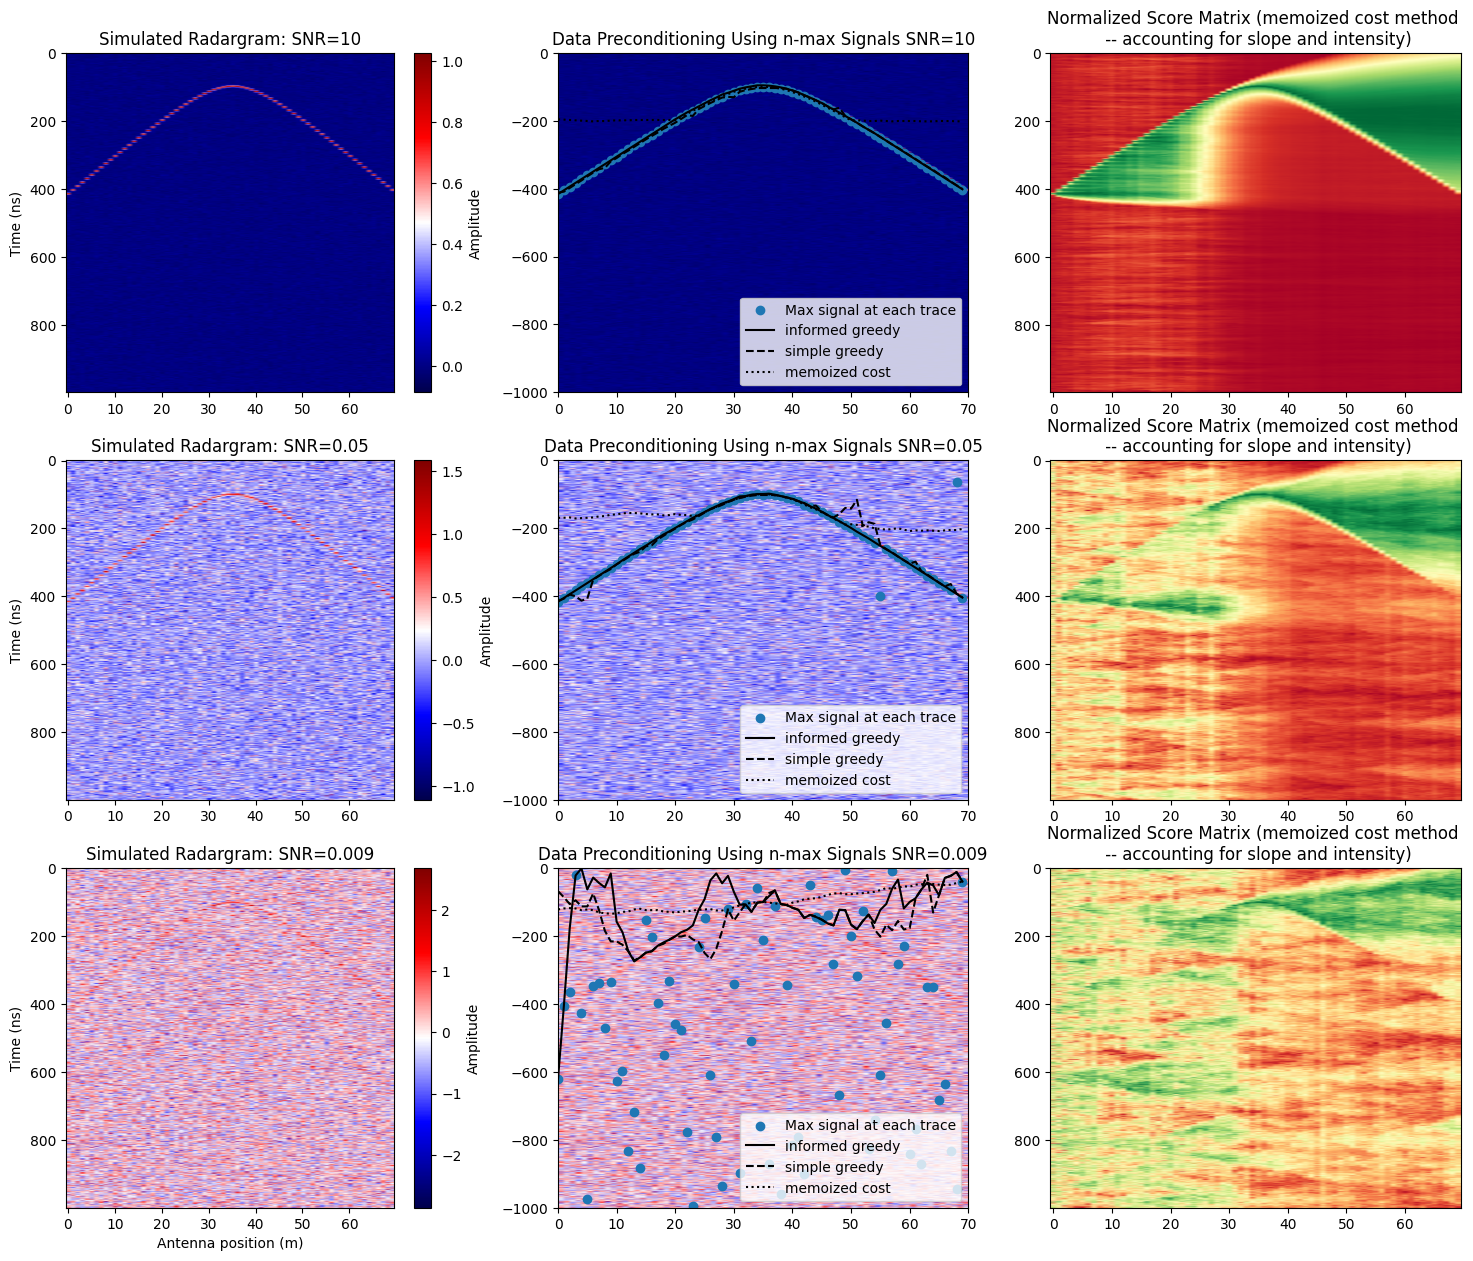

In [176]:
def visualize_preconditioning():
    fig, ax = plt.subplots(3, 3, figsize=(18,15))
    
    for SNR, i in zip([10, 0.05, 0.009], range(0,3)):
        # Parameters
        eps_r = 3                  # relative dielectric permittivity
        rf = 400e6                 # radar frequency different from pulse frequency
        dt = 1e-9                  # seconds
        dx = 1                     # meters
        region_shape = (70, 1e-6)  # grid (x,z)
        wavetype = 'gaussian'
        
        # Point reflectors at (x,t) where x [m] and t [s]
        reflectors = [(35, 50e-9)]
        
        data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
        
        im = ax[i][0].imshow(data, aspect='auto', cmap='seismic')
        if i == 2:
            ax[i][0].set_xlabel("Antenna position (m)")
        ax[i][0].set_ylabel("Time (ns)")
        ax[i][0].set_title(f"Simulated Radargram: SNR={SNR}")
        cbar = fig.colorbar(im, label="Amplitude")
        
        t, x = data.argsort(axis=0)[::-1,:][0], np.arange(0, data.shape[1]) * dx 
        x_window, t_window = gprsim.minimize_tracewise_slope_window(data, 20, 1, 5)
        x_greedy, t_greedy = gprsim.minimize_tracewise_slope_greedy(data, 15, dx)
        x_dynamic, t_dynamic, c, b = gprsim.smooth_path_dp(data, dx, lam=0.01)
        
        ax[i][1].set_title(f"Data Preconditioning Using n-max Signals SNR={SNR}")
        im1 = ax[i][1].imshow(data, aspect='auto', extent=[0,70,-1000,0], cmap='seismic')
        ax[i][1].scatter(x, -t, label="Max signal at each trace")
        ax[i][1].plot(x_window, -t_window, label="informed greedy", c='black', linestyle='-')
        ax[i][1].plot(x_greedy, -t_greedy, label="simple greedy", c='black', linestyle='--')
        ax[i][1].plot(x_dynamic, t_dynamic, label="memoized cost", c='black', linestyle=':')
        ax[i][1].legend(loc="lower right")
    
    
        im2 = ax[i][2].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)), aspect='auto', cmap='RdYlGn')
        ax[i][2].set_title("Normalized Score Matrix (memoized cost method \n -- accounting for slope and intensity)")
visualize_preconditioning()

## A really noisy simulation

Text(0.5, 235.72222222222223, 'x distance (m)')

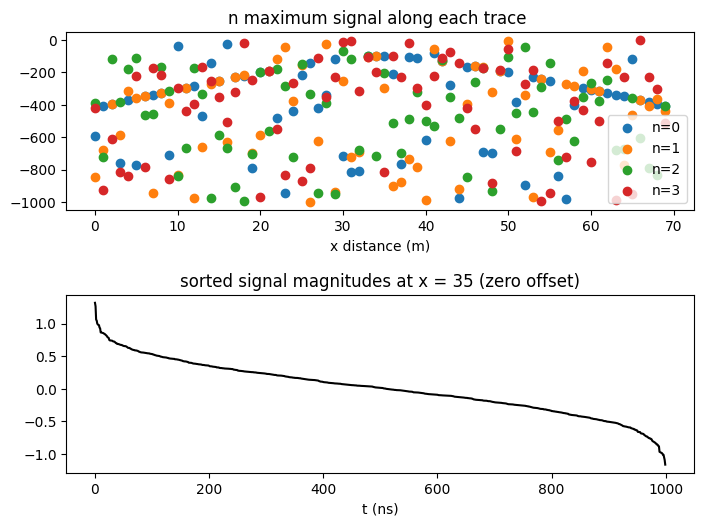

In [178]:
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
SNR = 0.02

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)

fig, ax = plt.subplots(2, figsize = (7,5))
fig.tight_layout(h_pad=4)

for n in range(0,4):
    t = data.argsort(axis=0)[::-1,:][n]* -1 # Ttake the indices of the max 5 signals
    x = np.arange(0, data.shape[1]) * dx # 
    ax[0].scatter(x, t, label=f"n={n}")

sample_signal = data[:,35]
ax[1].plot(np.sort(sample_signal)[::-1], c='black')
ax[1].set_title("sorted signal magnitudes at x = 35 (zero offset)")
ax[1].set_xlabel("t (ns)")
ax[0].legend()
ax[0].set_title("n maximum signal along each trace ")
ax[0].set_xlabel("x distance (m)")

# This looks quite nice, Lets gradually degrade the SNR ot see how the alg responds

In [182]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
wavetype = 'gaussian'
# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]
x_0, t_0 = reflectors[0][0], reflectors[0][1]

drs = []
dx0s = []
dt0s = []
for SNR in np.arange(0.0009,0.2,0.002):
    data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
    v, z, x0, t0 = gprsim.fit_hyperbola(data, 1, 'robust_fit', dx, dt, lam=0.001)
    drs.append(((np.abs(eps_r-(3e8/v)**2)) / ((np.abs(eps_r+(3e8/v)**2))/2))*100)
    dx0s.append(((np.abs(x_0-x0)) / ((np.abs(x_0+x0)/2)))*100)
    dt0s.append(((np.abs(t_0-t0)) / ((np.abs(t_0+t0)/2)))*100)
        

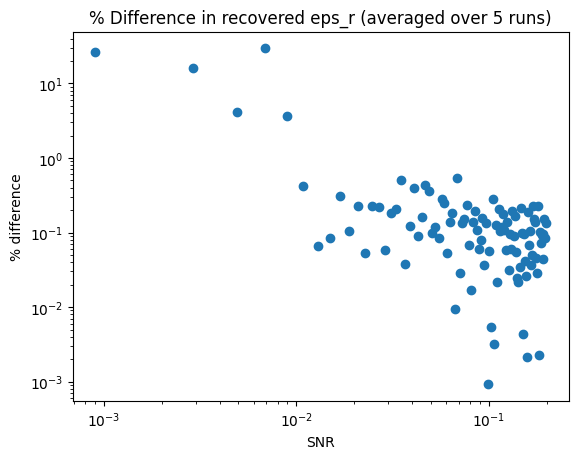

In [187]:
plt.scatter(np.arange(0.0009,0.2,0.002), drs); plt.title("% Difference in recovered eps_r (averaged over 5 runs)"); plt.xlabel("SNR"); plt.ylabel("% difference"); plt.xscale('log'); plt.yscale('log'); 


Caught invalud value in sqrt: can not calculate hyperbola parameters from pinv. Switching to np.polyfit to avoid distruption. If np.polyfit quits, the input data may be too noisy
v = nan m/s, depth z = nan m, apex x0 = 9.000 m, t0 = 5e-10 s
Caught invalud value in sqrt: can not calculate hyperbola parameters from pinv. Switching to np.polyfit to avoid distruption. If np.polyfit quits, the input data may be too noisy
v = nan m/s, depth z = nan m, apex x0 = 9.000 m, t0 = 5e-10 s
Caught invalud value in sqrt: can not calculate hyperbola parameters from pinv. Switching to np.polyfit to avoid distruption. If np.polyfit quits, the input data may be too noisy
v = nan m/s, depth z = nan m, apex x0 = 9.000 m, t0 = 5e-10 s


/var/folders/vv/wqjks1114hz5w6vtzybkd8gc0000gn/T/ipykernel_17257/4065313890.py:49: RuntimeWarning: invalid value encountered in sqrt
  v = 2.0 / np.sqrt(slope)      # subsurface velocity (m/s)


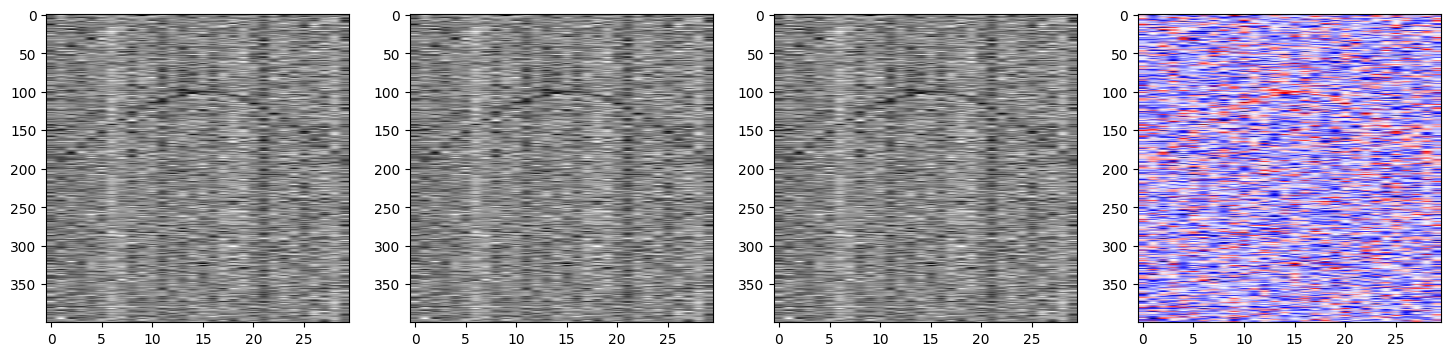

In [189]:
fig, ax = plt.subplots(1,4, figsize=(18,4))
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
nx = 70
nt = 1e-6
region_shape = (nx, nt)  # grid (x,z)
wavetype = 'gaussian'
SNR = 0.01

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
data = data[0:400, 20:50]
# im = ax[0].imshow(c-c.mean(axis=0), aspect="auto")
# im = ax[0].imshow(data, aspect="auto", cmap='binary', alpha=0.4)
# im2 = ax[1].imshow(data, aspect="auto", cmap='binary', alpha=0.4)
# im3 = ax[2].imshow(data, aspect="auto", cmap='binary', alpha=0.4)

'''
Plot the intensity only case
'''
x, t, c, b = smooth_path_dp(data, dx, lam=0) # Intensity only path
ax[0].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)),cmap='binary', aspect='auto')
v, z, x0, t0 = fit_hyperbola(data, 1, 'robust_fit', dx, dt, x, t)
ax[0].plot(x, (2*np.sqrt((x-x0)**2 + z**2))/(v*1e-9), c='tab:red', ls='--', lw=2)

'''
Plot the slope only case
'''
x, t, c, b = smooth_path_dp(data, dx, lam=1)
ax[1].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)),cmap='binary', aspect='auto')
v, z, x0, t0 = fit_hyperbola(data, 1, 'robust_fit', dx, dt, x, t)
ax[1].plot(x, (2*np.sqrt((x-x0)**2 + z**2))/(v*1e-9), c='tab:blue', ls='--', lw=2)

'''rfd
plot the optimal case
'''
# x, t, c, b = smooth_path_dp(data, dx, lam=0.001)
# ax[2].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)),cmap='binary', aspect='auto')
# v, z, x0, t0 = fit_hyperbola(data, 1, 'robust_fit', dx, dt, 0.001)
# ax[2].plot(x, (2*np.sqrt((x-x0)**2 + z**2))/(v*1e-9), c='y', ls='--', lw=2)
x, t = gprsim.minimize_tracewise_slope_window(data, 100, dx, 5)
v, z, x0, t0 = fit_hyperbola(data, 1, 'robust_fit', dx, dt, x, t)
ax[2].imshow((c-c.min(axis=0))/(c.max(axis=0)-c.min(axis=0)),cmap='binary', aspect='auto')
ax[2].plot(x, (2*np.sqrt((x-x0)**2 + z**2))/(v*1e-9), c='y', ls='--', lw=2)


ax[3].imshow(data, aspect="auto", cmap='seismic')



In [173]:
import numpy as np

def sec(theta):
    return 1/(np.cos(theta))
    
def transmission_angles(er, h, xq, zq, xa):
    # theta_gv: 0 → pi/2, with 2^11 points
    theta_gv = np.linspace(0, np.pi/2, 2**11)

    # theta_av = asin(min(sqrt(er)*sin(theta_gv), 1))
    # np.minimum applies elementwise
    inside = np.sqrt(er) * np.sin(theta_gv)
    inside = np.minimum(inside, 1.0)
    theta_av = np.arcsin(inside)

    # Compute absolute error array exactly like MATLAB
    diff = np.abs(np.abs(xa - xq) - zq * np.tan(theta_gv) - h * np.tan(theta_av))

    # Find index of minimum
    ind_min = np.argmin(diff)

    # Return angles
    theta_a = theta_av[ind_min]
    theta_g = theta_gv[ind_min]

    return theta_a, theta_g

def kirchoff_migration_2D(B, h, er, t, xA, xQ, zQ):
    # B: preprocessed B-scan
    # h: Antenna height
    # er: relative permitivity
    # t = time vector
    # zA: spatial vecotr (sampling)

    # output I: image, claculated as xQ x zQ rectangle , abs[I], rows should be depth, cols should be xQ

    c = 3e8 # speed of light in a vac
    Nt = t.shape[0]
    NxQ = xQ.shape[0]
    NzQ = zQ.shape[0]
    NxA = xA.shape[0]
    
    # Initialize the kernel
    kernel = np.zeros((NxA, NxQ, NxQ))
    print(kernel.shape)

    # calculate the half derivative
    Fs = None # sampling frequency
    f = None   

    # B_f = np.fft.fftshift(np.fft.fft(B, 0), 0) # f-x domain
    # D12 = np.tile(np.sqrt(1j * 2 * np.pi * f.T), (1,NxA)) # half derivative operator
    # dB = np.real(np.ifft(np.fft.fftshift(D12*B_f, 1), 1))
    dB = B

    for m in range(NxQ):
        xq = xQ[m]
        for n in range(NzQ):
            zq = zQ[n]
            theta_av = np.zeros((NxA, 1))
            theta_gv = np.zeros((NxA, 1))
            for p in range(NxA):
                (theta_a, theta_g) = transmission_angles(er, h, xq, zq, xA[p])
                theta_av[p] = theta_a
                theta_gv[p] = theta_g
            r = h * sec(theta_av) + zq * sec(theta_gv)
            t_exps = 2*(h*sec(theta_av/c) + zq*sec(theta_gv)/(c*np.sqrt(er)))

            # select the correct theta from dB
            # Trace out the hyp
            # replicate MATLAB repmat(t, [NxA, 1])
            t_rep = np.tile(t, (NxA, 1))      # shape: (NxA, len(t))
            
            # find index of minimum along axis=1 (MATLAB dim=2)
            inds = np.argmin(np.abs(t_rep - t_exps), axis=1)
            
            # convert (row, col) pairs → linear indices like MATLAB sub2ind
            rows = inds                     # row indices
            cols = np.arange(1, NxA+1) - 1  # MATLAB 1:NxA → Python 0:NxA-1
            
            # linearized index into dB
            lin_inds = rows * dB.shape[1] + cols
            
            # construct the kernel
            print((np.cos(theta_av)/np.sqrt(r)).shape)
            kernel[:, m, n] = np.cos(theta_av)/np.sqrt(r) * dB[lin_inds]

    I = np.abs(np.trapz(kernelm, x=zA, axis=0)).squeeze().T
    return I

    
    
# Read in B-scan data
B = data
meta = None

x = np.arange(nx) # positions of scans
t = np.arange(nt) # time

# perform preprocessing
BKGR = B-B.mean(axis=0)

# No filtering
BKGR_filtered = BKGR

# perform kirchoff migration
h = 0.1 # Height of the antenna
er = 3.0 # rel permitivity
xQ = x
zQ = np.arange(0, 0.4, 5e-3) # Why a 5mm increment?
I = kirchoff_migration_2D(BKGR_filtered, h, er, t, x, xQ, zQ)
plt.imshow(I, apect='auto')

(70, 70, 70)
(70, 1)


ValueError: could not broadcast input array from shape (70,30) into shape (70,)